In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import shutil
import numpy as np
import pandas as pd
import tensorflow as tf

import csv
import os
import sys
import glob
import operator
import time

import seaborn as sn

import matplotlib.pyplot as plt

from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical, normalize

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import TensorBoard

print(tf.__version__)

2021-09-20 10:33:50.004011: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Using TensorFlow backend.


2.3.0


In [4]:
def loadData(csvFile):
    pickleDump = '{}.pickle'.format(csvFile)
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
    else:
        df = pd.read_csv(csvFile, low_memory=False, na_values='NaN')
        df = df.rename(str.strip, axis='columns')
        for col in df.columns:
            indexNames = df[df[col]=='Infinity'].index
            if not indexNames.empty:
                print('deleting {} rows with Infinity in column {}'.format(len(indexNames), col))
                df.drop(indexNames, inplace=True)
        
        df.to_pickle(pickleDump)
    
    return df


In [5]:
def baseline_model(inputDim=-1,outputDim=-1):
    global model_extension, experimentTitle
    model = tf.keras.Sequential([
        Dense(128, activation='relu', input_shape=(inputDim,)),
        BatchNormalization(),
        Dropout(.5),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(.5),
        Dense(outputDim, activation='softmax')
    ]) 
    if outputDim > 2:
        print('Categorical Cross-Entropy Loss Function With Gpu')
        model_extension = "_categorical_gpu"
        experimentTitle = "Categorical_GPU"
        model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    else:
        print('Binary Cross-Entropy Loss Functionwith With GPU')
        model_extension = "_binary_gpu"
        experimentTitle = "Binary_GPU"
        model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

    return model

In [6]:
def encode_labels(dataframe):
    dataframe=dataframe.copy()
    data_y=dataframe.pop(dep_var)
    encoder = LabelEncoder()
    encoder.fit(data_y)
    data_y = encoder.transform(data_y)
    dummy_y = to_categorical(data_y)
    return dummy_y

In [7]:
def plotAccuracy(title):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [8]:
def plotLoss(title):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [9]:
def experiment(dataframe, early=False):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

    encoded_y = dataframe.copy()
    encoded_y = encode_labels(encoded_y)
    X=StandardScaler().fit_transform(dataframe.drop(dep_var, axis=1))
    y=LabelEncoder().fit_transform(dataframe[dep_var].values)
    start_time = time.time()

    for index, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
        
        xtrain, xval = X[train_indices], X[val_indices]
        ytrain, yval = encoded_y[train_indices], encoded_y[val_indices]

        inputDim=xtrain.shape[1]
        outputDim=ytrain.shape[1]
        print("Running fold #" + str(index+1))

        model = baseline_model(inputDim,outputDim)
        
        time_gen = int(time.time())
        
        global model_name
        model_name = f"{dataFile}_{time_gen}"

        tensorboard = TensorBoard(log_dir='keras_tensorflow_logs/{}/{}_{}'.format(experimentTitle, model_name, model_extension),update_freq='epoch')
        if early_stop:
            callbacks = [tensorboard, early_stop]
        else:
            callbacks = [tensorboard]
        history = model.fit(xtrain, ytrain, epochs=epochs, validation_data=(xval,yval), callbacks=callbacks, batch_size=batch_size, verbose=0)
        
    global end_time 
    end_time = time.time() - start_time
    remain_seconds = 60%end_time
 
    global Minutes 
    Minutes = int(end_time/60)
    print("Time to complete {} min {} sec".format(Minutes, end_time))
        
    return model, history, X, encoded_y


In [10]:
df1 = loadData('/root/FinalDataset/All.csv')
df1=df1.dropna(axis=1)

In [ ]:
for file in glob.glob('keras_tensorflow_logs/Categorical_GPU*'):
    if os.path.exists(file):
        shutil.rmtree(file)
for file in glob.glob('keras_tensorflow_logs/Binary_GPU*'):
    if os.path.exists(file):
        shutil.rmtree(file)

In [11]:
df1.columns

Index(['Querylength', 'domain_token_count', 'path_token_count',
       'avgdomaintokenlen', 'longdomaintokenlen', 'avgpathtokenlen', 'tld',
       'charcompvowels', 'charcompace', 'ldl_url', 'ldl_domain', 'ldl_path',
       'ldl_filename', 'ldl_getArg', 'dld_url', 'dld_domain', 'dld_path',
       'dld_filename', 'dld_getArg', 'urlLen', 'domainlength', 'pathLength',
       'subDirLen', 'fileNameLen', 'this.fileExtLen', 'ArgLen', 'pathurlRatio',
       'ArgUrlRatio', 'argDomanRatio', 'domainUrlRatio', 'pathDomainRatio',
       'argPathRatio', 'executable', 'isPortEighty', 'NumberofDotsinURL',
       'ISIpAddressInDomainName', 'CharacterContinuityRate',
       'LongestVariableValue', 'URL_DigitCount', 'host_DigitCount',
       'Directory_DigitCount', 'File_name_DigitCount', 'Extension_DigitCount',
       'Query_DigitCount', 'URL_Letter_Count', 'host_letter_count',
       'Directory_LetterCount', 'Filename_LetterCount',
       'Extension_LetterCount', 'Query_LetterCount', 'LongestPathToken

In [12]:
df1.shape

(18982, 80)

In [13]:
df1.head()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
35,0,4,4,6.25,17,3.75,4,4,2,0,...,1,0,-1,0.726945,0.768811,0.916667,1.000000,1.000000,-1.000000,Defacement
37,22,4,10,6.25,17,3.50,4,19,10,0,...,9,8,7,0.686486,0.768811,0.916667,0.748105,0.757206,0.749167,Defacement
38,23,4,10,6.25,17,3.50,4,19,10,0,...,9,8,7,0.687286,0.768811,0.916667,0.747622,0.756298,0.748268,Defacement
39,22,4,10,6.25,17,3.50,4,19,10,0,...,9,8,7,0.683476,0.768811,0.916667,0.742090,0.750292,0.741506,Defacement
40,23,4,10,6.25,17,3.50,4,19,10,0,...,9,8,7,0.687286,0.768811,0.916667,0.747622,0.756298,0.748268,Defacement


In [15]:
label = 'URL_Type_obf_Type'
lblTypes=set(df1[label])
for lbl in lblTypes:
    print('| {} | {} |'.format(lbl, len(df1[df1[label] == lbl].index)))

| malware | 4440 |
| spam | 5342 |
| benign | 2709 |
| Defacement | 2477 |
| phishing | 4014 |


In [16]:
dataPath = 'FinalDataset'
dep_var = label

In [17]:
df1.argPathRatio = df1['argPathRatio'].astype('float')

In [18]:
dataFile = 'All.csv'
epochs=100
batch_size=64

In [20]:
seed = 7
np.random.seed(seed)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### Run the experiment

In [21]:
categorical_df = df1.copy()
model, history, X , encoded_y = experiment(categorical_df,early=True)

Running fold #1


2021-09-20 10:36:46.954529: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-09-20 10:36:46.989734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-20 10:36:46.990423: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:07.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-09-20 10:36:46.990462: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-09-20 10:36:47.060070: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-09-20 10:36:47.090525: I tensorflow/stream_executor/platform/default/d

Categorical Cross-Entropy Loss Function With Gpu


2021-09-20 10:36:49.440837: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:36:49.446350: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1391] Profiler found 1 GPUs
2021-09-20 10:36:49.446736: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcupti.so.10.1'; dlerror: libcupti.so.10.1: cannot open shared object file: No such file or directory
2021-09-20 10:36:49.446823: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcupti.so'; dlerror: libcupti.so: cannot open shared object file: No such file or directory
2021-09-20 10:36:49.446834: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-20 10:36:50.238046: I tensorflow/stream_executor/platform/default/dso_

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2021-09-20 10:36:51.102818: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:36:51.102889: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-20 10:36:51.112722: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-20 10:36:51.122502: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: keras_tensorflow_logs/Categorical_GPU/All.csv_1632105409__categorical_gpu/train/plugins/profile/2021_09_20_10_36_51
2021-09-20 10:36:51.123530: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to keras_tensorflow_logs/Categorical_GPU/All.csv_1632105409__categorical_gpu/train/plugins/profile/2021_09_20_10_36_51/iZj

Running fold #2
Categorical Cross-Entropy Loss Function With Gpu


2021-09-20 10:37:31.691055: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:37:31.691123: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-20 10:37:32.365738: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:37:32.365796: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-20 10:37:32.413251: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-20 10:37:32.414562: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: keras_tensorflow_logs/Categorical_GPU/All.csv_1632105451__categorical_gpu/train/plugins/profile/2021_09_20_10_37_32
2021-09-20 10:37:32.415024: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to keras_tensorflow_logs/Categorical_GPU/All.csv_1632105451__categorical_gpu/train/plugins/profile/2021_09_20_10_37_32/iZj

Running fold #3
Categorical Cross-Entropy Loss Function With Gpu


2021-09-20 10:38:12.441311: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:38:12.441375: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-20 10:38:13.276754: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:38:13.276820: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-20 10:38:13.320669: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-20 10:38:13.322009: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: keras_tensorflow_logs/Categorical_GPU/All.csv_1632105492__categorical_gpu/train/plugins/profile/2021_09_20_10_38_13
2021-09-20 10:38:13.322478: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to keras_tensorflow_logs/Categorical_GPU/All.csv_1632105492__categorical_gpu/train/plugins/profile/2021_09_20_10_38_13/iZj

Running fold #4
Categorical Cross-Entropy Loss Function With Gpu


2021-09-20 10:39:03.908883: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:39:03.908948: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-20 10:39:04.587751: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:39:04.587808: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-20 10:39:04.632105: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-20 10:39:04.633410: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: keras_tensorflow_logs/Categorical_GPU/All.csv_1632105543__categorical_gpu/train/plugins/profile/2021_09_20_10_39_04
2021-09-20 10:39:04.633888: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to keras_tensorflow_logs/Categorical_GPU/All.csv_1632105543__categorical_gpu/train/plugins/profile/2021_09_20_10_39_04/iZj

Running fold #5
Categorical Cross-Entropy Loss Function With Gpu


2021-09-20 10:39:32.946192: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:39:32.946260: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-20 10:39:33.628473: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:39:33.628533: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-20 10:39:33.673785: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-20 10:39:33.675094: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: keras_tensorflow_logs/Categorical_GPU/All.csv_1632105572__categorical_gpu/train/plugins/profile/2021_09_20_10_39_33
2021-09-20 10:39:33.675554: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to keras_tensorflow_logs/Categorical_GPU/All.csv_1632105572__categorical_gpu/train/plugins/profile/2021_09_20_10_39_33/iZj

Running fold #6
Categorical Cross-Entropy Loss Function With Gpu


2021-09-20 10:40:04.391702: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:40:04.391766: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-20 10:40:05.085796: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:40:05.085857: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-20 10:40:05.133646: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-20 10:40:05.134983: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: keras_tensorflow_logs/Categorical_GPU/All.csv_1632105604__categorical_gpu/train/plugins/profile/2021_09_20_10_40_05
2021-09-20 10:40:05.135461: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to keras_tensorflow_logs/Categorical_GPU/All.csv_1632105604__categorical_gpu/train/plugins/profile/2021_09_20_10_40_05/iZj

Running fold #7
Categorical Cross-Entropy Loss Function With Gpu


2021-09-20 10:40:50.932636: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:40:50.932704: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-20 10:40:51.632365: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:40:51.632434: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-20 10:40:51.679864: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-20 10:40:51.681212: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: keras_tensorflow_logs/Categorical_GPU/All.csv_1632105650__categorical_gpu/train/plugins/profile/2021_09_20_10_40_51
2021-09-20 10:40:51.681694: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to keras_tensorflow_logs/Categorical_GPU/All.csv_1632105650__categorical_gpu/train/plugins/profile/2021_09_20_10_40_51/iZj

Running fold #8
Categorical Cross-Entropy Loss Function With Gpu


2021-09-20 10:41:33.750106: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:41:33.750171: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-20 10:41:34.733794: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:41:34.733859: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-20 10:41:34.783460: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-20 10:41:34.784931: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: keras_tensorflow_logs/Categorical_GPU/All.csv_1632105693__categorical_gpu/train/plugins/profile/2021_09_20_10_41_34
2021-09-20 10:41:34.785438: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to keras_tensorflow_logs/Categorical_GPU/All.csv_1632105693__categorical_gpu/train/plugins/profile/2021_09_20_10_41_34/iZj

Running fold #9
Categorical Cross-Entropy Loss Function With Gpu


2021-09-20 10:42:17.212930: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:42:17.213005: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-20 10:42:18.041455: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:42:18.041533: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-20 10:42:18.130726: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-20 10:42:18.133181: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: keras_tensorflow_logs/Categorical_GPU/All.csv_1632105737__categorical_gpu/train/plugins/profile/2021_09_20_10_42_18
2021-09-20 10:42:18.133979: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to keras_tensorflow_logs/Categorical_GPU/All.csv_1632105737__categorical_gpu/train/plugins/profile/2021_09_20_10_42_18/iZj

Running fold #10
Categorical Cross-Entropy Loss Function With Gpu


2021-09-20 10:43:02.098619: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:43:02.098693: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-20 10:43:02.868828: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:43:02.868913: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-20 10:43:02.941980: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-20 10:43:02.944274: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: keras_tensorflow_logs/Categorical_GPU/All.csv_1632105782__categorical_gpu/train/plugins/profile/2021_09_20_10_43_02
2021-09-20 10:43:02.945006: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to keras_tensorflow_logs/Categorical_GPU/All.csv_1632105782__categorical_gpu/train/plugins/profile/2021_09_20_10_43_02/iZj

Time to complete 7 min 422.6613483428955 sec


#### Save the model as a file

In [22]:
model.save('{}.model'.format(os.path.basename(dataPath)))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2021-09-20 10:44:30.478957: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: FinalDataset.model/assets


### Model Results

In [23]:
scores = model.evaluate(X,encoded_y, batch_size=batch_size,verbose=1)
print(model.metrics_names)
acc, loss = scores[1]*100, scores[0]
print('GPU Baseline: accuracy: {:.2f}%: loss: {:.2f}'.format(acc, loss))

297/297 [==============================] - 0s 1ms/step - loss: 0.0990 - accuracy: 0.9657
['loss', 'accuracy']
GPU Baseline: accuracy: 96.57%: loss: 0.10


#### Generate predictions from the model

In [24]:
prediction_y = model.predict_classes(X, batch_size=batch_size, verbose=1)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
297/297 [==============================] - 0s 797us/step


#### Confusion Matrix

<AxesSubplot:>

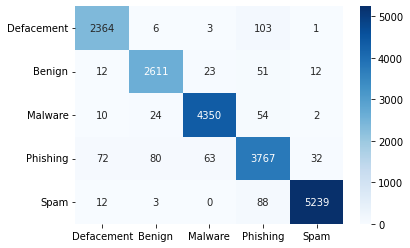

In [25]:
y=LabelEncoder().fit_transform(categorical_df[dep_var].values)
cm = confusion_matrix(y, prediction_y)
sn.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Defacement','Benign','Malware','Phishing','Spam'],
           yticklabels=['Defacement','Benign','Malware','Phishing','Spam'])

#### Graph of Categorical Cross-Entropy Model

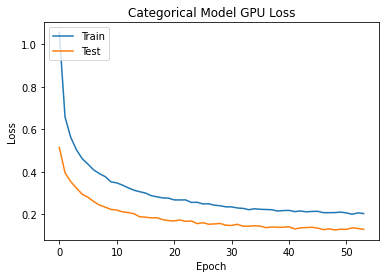

In [27]:
plotLoss('Categorical Model GPU Loss')

In [30]:
#transform mutlti to binary classification
lblTypes = list(lblTypes)
lblTypes = dict(zip(lblTypes, [1, 1, 1, 1, 1]))
lblTypes['benign'] = 0

In [31]:
binary_df = df1.copy()
binary_df[label] = binary_df[label].map(lblTypes)

### Train the Binary Model

In [32]:
model, history, X , encoded_y = experiment(binary_df)

Running fold #1
Binary Cross-Entropy Loss Functionwith With GPU


2021-09-20 10:46:02.789866: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:46:02.789947: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-20 10:46:03.861376: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:46:03.861443: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-20 10:46:03.921403: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-20 10:46:03.922908: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: keras_tensorflow_logs/Binary_GPU/All.csv_1632105962__binary_gpu/train/plugins/profile/2021_09_20_10_46_03
2021-09-20 10:46:03.923411: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to keras_tensorflow_logs/Binary_GPU/All.csv_1632105962__binary_gpu/train/plugins/profile/2021_09_20_10_46_03/iZj6c6wg0n65vdhgva0emgZ

Running fold #2
Binary Cross-Entropy Loss Functionwith With GPU


2021-09-20 10:46:37.150101: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:46:37.150170: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-20 10:46:37.943964: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:46:37.944030: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-20 10:46:37.995435: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-20 10:46:37.996886: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: keras_tensorflow_logs/Binary_GPU/All.csv_1632105997__binary_gpu/train/plugins/profile/2021_09_20_10_46_37
2021-09-20 10:46:37.997406: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to keras_tensorflow_logs/Binary_GPU/All.csv_1632105997__binary_gpu/train/plugins/profile/2021_09_20_10_46_37/iZj6c6wg0n65vdhgva0emgZ

Running fold #3
Binary Cross-Entropy Loss Functionwith With GPU


2021-09-20 10:46:59.448008: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:46:59.448072: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-20 10:47:00.238487: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:47:00.238553: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-20 10:47:00.289129: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-20 10:47:00.290518: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: keras_tensorflow_logs/Binary_GPU/All.csv_1632106019__binary_gpu/train/plugins/profile/2021_09_20_10_47_00
2021-09-20 10:47:00.291001: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to keras_tensorflow_logs/Binary_GPU/All.csv_1632106019__binary_gpu/train/plugins/profile/2021_09_20_10_47_00/iZj6c6wg0n65vdhgva0emgZ

Running fold #4
Binary Cross-Entropy Loss Functionwith With GPU


2021-09-20 10:47:39.252078: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:47:39.252148: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-20 10:47:40.043928: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:47:40.043995: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-20 10:47:40.094248: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-20 10:47:40.095624: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: keras_tensorflow_logs/Binary_GPU/All.csv_1632106059__binary_gpu/train/plugins/profile/2021_09_20_10_47_40
2021-09-20 10:47:40.096101: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to keras_tensorflow_logs/Binary_GPU/All.csv_1632106059__binary_gpu/train/plugins/profile/2021_09_20_10_47_40/iZj6c6wg0n65vdhgva0emgZ

Running fold #5
Binary Cross-Entropy Loss Functionwith With GPU


2021-09-20 10:48:10.071530: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:48:10.071609: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-20 10:48:10.873188: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:48:10.873262: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-20 10:48:10.922957: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-20 10:48:10.924318: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: keras_tensorflow_logs/Binary_GPU/All.csv_1632106090__binary_gpu/train/plugins/profile/2021_09_20_10_48_10
2021-09-20 10:48:10.924801: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to keras_tensorflow_logs/Binary_GPU/All.csv_1632106090__binary_gpu/train/plugins/profile/2021_09_20_10_48_10/iZj6c6wg0n65vdhgva0emgZ

Running fold #6
Binary Cross-Entropy Loss Functionwith With GPU


2021-09-20 10:48:40.729337: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:48:40.729398: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-20 10:48:41.838390: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:48:41.838458: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-20 10:48:41.903025: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-20 10:48:41.904529: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: keras_tensorflow_logs/Binary_GPU/All.csv_1632106120__binary_gpu/train/plugins/profile/2021_09_20_10_48_41
2021-09-20 10:48:41.905028: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to keras_tensorflow_logs/Binary_GPU/All.csv_1632106120__binary_gpu/train/plugins/profile/2021_09_20_10_48_41/iZj6c6wg0n65vdhgva0emgZ

Running fold #7
Binary Cross-Entropy Loss Functionwith With GPU


2021-09-20 10:49:07.081520: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:49:07.081583: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-20 10:49:07.913644: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:49:07.913707: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-20 10:49:07.966797: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-20 10:49:07.968290: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: keras_tensorflow_logs/Binary_GPU/All.csv_1632106147__binary_gpu/train/plugins/profile/2021_09_20_10_49_07
2021-09-20 10:49:07.968819: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to keras_tensorflow_logs/Binary_GPU/All.csv_1632106147__binary_gpu/train/plugins/profile/2021_09_20_10_49_07/iZj6c6wg0n65vdhgva0emgZ

Running fold #8
Binary Cross-Entropy Loss Functionwith With GPU


2021-09-20 10:49:48.463702: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:49:48.463770: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-20 10:49:49.282395: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:49:49.282459: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-20 10:49:49.333614: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-20 10:49:49.335037: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: keras_tensorflow_logs/Binary_GPU/All.csv_1632106188__binary_gpu/train/plugins/profile/2021_09_20_10_49_49
2021-09-20 10:49:49.335571: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to keras_tensorflow_logs/Binary_GPU/All.csv_1632106188__binary_gpu/train/plugins/profile/2021_09_20_10_49_49/iZj6c6wg0n65vdhgva0emgZ

Running fold #9
Binary Cross-Entropy Loss Functionwith With GPU


2021-09-20 10:50:23.054556: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:50:23.054618: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-20 10:50:23.872032: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:50:23.872096: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-20 10:50:23.921824: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-20 10:50:23.923200: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: keras_tensorflow_logs/Binary_GPU/All.csv_1632106223__binary_gpu/train/plugins/profile/2021_09_20_10_50_23
2021-09-20 10:50:23.923703: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to keras_tensorflow_logs/Binary_GPU/All.csv_1632106223__binary_gpu/train/plugins/profile/2021_09_20_10_50_23/iZj6c6wg0n65vdhgva0emgZ

Running fold #10
Binary Cross-Entropy Loss Functionwith With GPU


2021-09-20 10:50:50.953286: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:50:50.953351: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-20 10:50:51.769727: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-09-20 10:50:51.769792: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1441] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-20 10:50:51.820202: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-20 10:50:51.821570: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: keras_tensorflow_logs/Binary_GPU/All.csv_1632106250__binary_gpu/train/plugins/profile/2021_09_20_10_50_51
2021-09-20 10:50:51.822040: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to keras_tensorflow_logs/Binary_GPU/All.csv_1632106250__binary_gpu/train/plugins/profile/2021_09_20_10_50_51/iZj6c6wg0n65vdhgva0emgZ

Time to complete 5 min 320.30143189430237 sec


### Model Results

In [33]:
scores = model.evaluate(X,encoded_y, verbose=1)
print(model.metrics_names)
acc, loss = scores[1]*100, scores[0]
print('GPU Baseline: accuracy: {:.2f}%: loss: {:.2f}'.format(acc, loss))

594/594 [==============================] - 1s 1ms/step - loss: 0.0318 - accuracy: 0.9886
['loss', 'accuracy']
GPU Baseline: accuracy: 98.86%: loss: 0.03


#### Predictions

In [34]:
prediction_y = model.predict_classes(X, batch_size=batch_size, verbose=1)

297/297 [==============================] - 0s 759us/step


<AxesSubplot:>

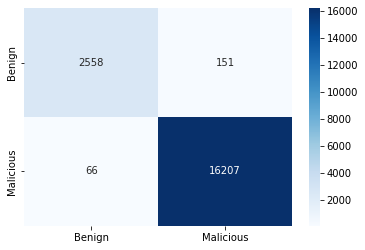

In [35]:
y=LabelEncoder().fit_transform(binary_df[dep_var].values)
cm = confusion_matrix(y, prediction_y)
sn.heatmap(cm, cmap='Blues', annot=True, fmt='g', xticklabels=['Benign', 'Malicious'],
        yticklabels=['Benign', 'Malicious'])

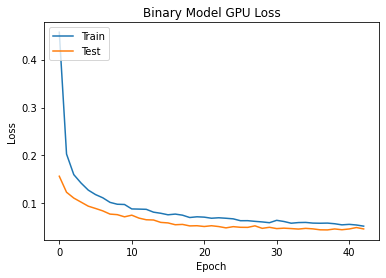

In [37]:
plotLoss('Binary Model GPU Loss')